In [3]:
scores = '../out/ko_scores.txt'
bscores = '../out/ko_scores_rep.txt'

In [4]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [5]:
# other imports
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
def get_variance_function(v,
                          slices=10,
                          min_periods=20,
                          sample=None,
                          function=pd.Series.var):
    x = []
    y = []
    vmin = v['sum'].min()
    vmax = v['sum'].max()
    lv = None
    for rv in np.linspace(vmin, vmax, slices):
        if lv is None:
            lv = rv
            continue
        vs = v[(v['sum'] >= lv) & (v['sum'] <= rv)]
        if vs.shape[0] < min_periods:
            lv = rv
            continue
        if sample is not None:
            var = function(vs['sub'].sample(sample))
        else:
            var = function(vs['sub'])
        x.append((lv + rv) / 2)
        y.append(var)
    return x, y

def get_null(m):
    b1 = m.loc['B1']
    b2 = m.loc['B2']
    c1 = set(b1.index)
    c2 = set(b2.index)
    idx = sorted(c1.intersection(c2))
    a1 = b1.loc[idx]['score']
    a2 = b2.loc[idx]['score']
    a1.name = 'batch1'
    a2.name = 'batch2/3'
    v1 = (a1 + a2)
    v2 = (a1 - a2)
    v1.name = 'sum'
    v2.name = 'sub'
    v = a1.to_frame().join(a2.to_frame())
    v = v.join(v1.to_frame()).join(v2.to_frame())
    x, y = get_variance_function(v, 100,
                                 function=pd.Series.std)
    return x, y

bm = pd.read_table(bscores, index_col=[3, 1, 0, 2, 5])
x, y = get_null(bm)

In [22]:
def get_deviating_scores(m, s1, s2, x, y):
    a1 = m[s1]
    a2 = m[s2]
    v1 = (a1 + a2)
    v2 = (a1 - a2)
    v1.name = 'sum'
    v2.name = 'sub'
    w = a1.to_frame().join(a2.to_frame())
    w = w.join(v1.to_frame()).join(v2.to_frame())
    w['var'] = np.interp((a1 + a2),
                         x,
                         y)
    w['pval'] = [1 - stats.norm.cdf(np.abs(x/y), loc=0, scale=y)
                 for x,y in w[['sub', 'var']].values]
    w['qval'] = sm.stats.multipletests(w['pval'], method='fdr_bh')[1]
    return w

In [12]:
m = pd.read_table(scores, index_col=[0, 1, 2])['score']

In [13]:
ps = {}
pc = {}
pp = {}
p = pd.read_table(scores, index_col=[0, 1, 2])
for s in {x[0] for x in p.index}:
    v = p.loc[s]
    v = v[~v.index.duplicated()].dropna()
    v['phenotype'] = [1 if x < 0 and y <= 0.05
                      else 0
                      for x,y in v[['score', 'qvalue']].values]
    ps[s] = (v['phenotype'].sum(), v['phenotype'].sum() / v.shape[0])
    pc[s] = {}
    pp[s] = {}
    for c, value in v.groupby('condition').sum()['phenotype'].items():
        pc[s][c] = value
    for c, value in (v.groupby('condition').sum()['phenotype'] /
                     v.groupby('condition').count()['phenotype']).items():
        pp[s][c] = value

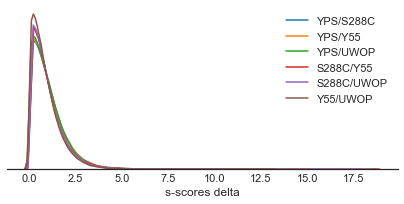

In [34]:
plt.figure(figsize=(7, 3))

res = []
res1 = []
for s1, s2 in itertools.combinations({x[0] for x in m.index}, 2):
    s = s1 + '/' + s2
    m1 = m.loc[s1]
    m1 = m1[~m1.index.duplicated()].dropna()
    m2 = m.loc[s2]
    m2 = m2[~m2.index.duplicated()].dropna()
    m1.name = s1
    m2.name = s2
    d = m1.to_frame().join(m2.to_frame(), how='inner').dropna()
    w = get_deviating_scores(d, s1, s2, x, y)
    v = w.groupby('gene').min()
    d['delta'] = abs(d[s1] - d[s2])
    d['diff'] = d['delta'] >= 4
    t = d.groupby('condition').sum()['diff']
    sns.kdeplot(data=d['delta'],
                label=s)
    res.append((s,
                ps[s1][0], ps[s2][0],
                ps[s1][1], ps[s2][1],
                d[d['delta'] >= 4].shape[0] / d.shape[0],
                d[d['delta'] >= 4].shape[0],
                d.shape[0],
                w[w['qval'] <= 1E-4].shape[0] / w.shape[0],
                w[w['qval'] <= 1E-4].shape[0],
                w.shape[0],
                v[v['qval'] <= 1E-4].shape[0] / v.shape[0]))
    for c, v in t.items():
        res1.append((s, c, pc[s1][c], pc[s2][c], v))

r = pd.DataFrame(res,
                 columns=['strains',
                          'pheno1',
                          'pheno2',
                          'pheno-proportion1',
                          'pheno-proportion2',
                          'proportion',
                          'different',
                          'total',
                          'wproportion',
                          'wdifferent',
                          'wtotal',
                          'wgene-prop'])
r1 = pd.DataFrame(res1,
                  columns=['strains',
                           'condition',
                           'pheno1', 'pheno2',
                           'different'])

plt.xlabel('s-scores delta')
plt.yticks([])
sns.despine(left=True);

In [36]:
r.sort_values('wproportion')

,strains,pheno1,pheno2,pheno-proportion1,pheno-proportion2,proportion,different,total,wproportion,wdifferent,wtotal,wgene-prop
5,Y55/UWOP,1809,1867,0.014552,0.015478,0.006793,973,143227,0.001843,264,143227,0.049492
2,YPS/UWOP,2646,1867,0.020985,0.015478,0.009634,1386,143861,0.003225,464,143861,0.079616
1,YPS/Y55,2646,1809,0.020985,0.014552,0.010638,1563,146926,0.003417,502,146926,0.081592
3,S288C/Y55,4393,1809,0.029021,0.014552,0.011987,1844,153834,0.005025,773,153834,0.121053
4,S288C/UWOP,4393,1867,0.029021,0.015478,0.012004,1784,148622,0.005295,787,148622,0.123127
0,YPS/S288C,2646,4393,0.020985,0.029021,0.014064,2189,155649,0.006226,969,155649,0.140583


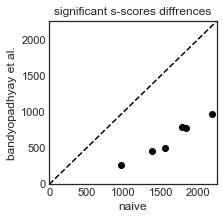

In [30]:
plt.figure(figsize=(3, 3))

plt.plot(r['different'],
         r['wdifferent'],
         'ko')

plt.plot([0, 2255],
         [0, 2255],
         'k--')

plt.xlim(0, 2255)
plt.ylim(0, 2255)

plt.xlabel('naive')
plt.ylabel('bandyopadhyay et al.')

plt.title('significant s-scores diffrences');

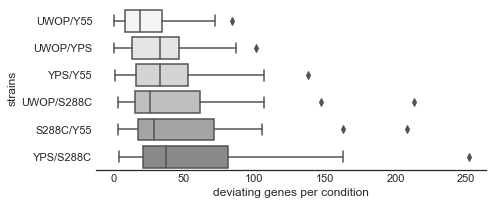

In [20]:
plt.figure(figsize=(7, 3))

sns.boxplot(data=r1,
            x='different',
            y='strains',
            order=r1.groupby('strains').mean()['different'].sort_values().index,
            palette=sns.color_palette('Greys', 10))
plt.xlabel('deviating genes per condition')
sns.despine(left=True);

In [21]:
r

,strains,pheno1,pheno2,pheno-proportion1,pheno-proportion2,proportion,different,total
0,UWOP/YPS,1867,2646,0.015478,0.020985,0.009634,1386,143861
1,UWOP/S288C,1867,4393,0.015478,0.029021,0.012004,1784,148622
2,UWOP/Y55,1867,1809,0.015478,0.014552,0.006793,973,143227
3,YPS/S288C,2646,4393,0.020985,0.029021,0.014064,2189,155649
4,YPS/Y55,2646,1809,0.020985,0.014552,0.010638,1563,146926
5,S288C/Y55,4393,1809,0.029021,0.014552,0.011987,1844,153834


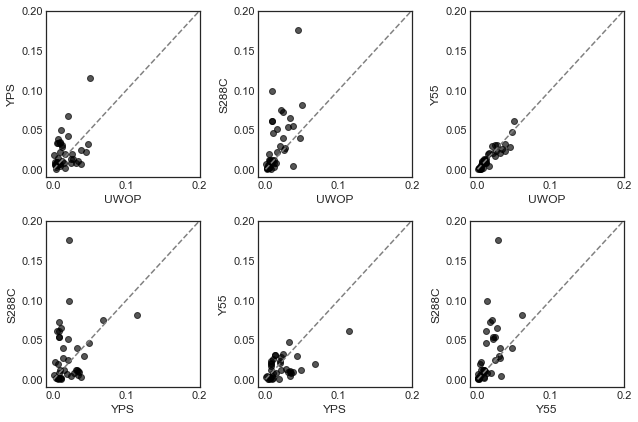

In [22]:
plt.figure(figsize=(9, 6))

conds = {y for x in pp
         for y in pp[x]}

i = 1
for s1, s2 in itertools.combinations(ps, 2):
    plt.subplot(2, 3, i)
    
    if s1 == 'S288C':
        tmp = s2
        s2 = s1
        s1 = tmp
    
    plt.plot([pp[s1].get(x, np.nan) for x in conds],
             [pp[s2].get(x, np.nan) for x in conds],
             'ko',
             alpha=0.66)
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    plt.plot([0, 0.2],
             [0, 0.2],
             '--',
             color='grey')
    
    plt.xlim(-0.01, 0.20)
    plt.ylim(-0.01, 0.20)
        
    i += 1

plt.tight_layout()

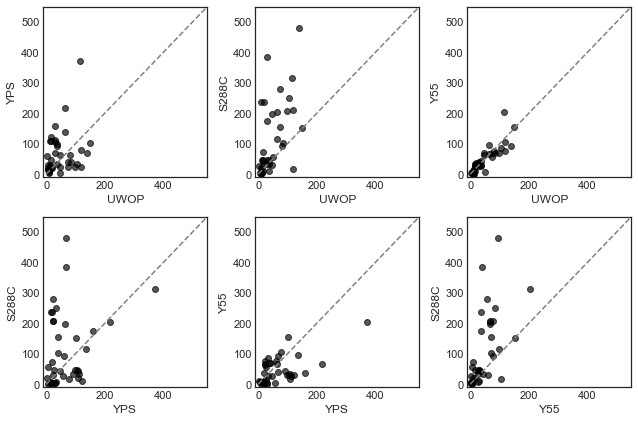

In [23]:
plt.figure(figsize=(9, 6))

conds = {y for x in pp
         for y in pp[x]}

i = 1
for s1, s2 in itertools.combinations(ps, 2):
    plt.subplot(2, 3, i)
    
    if s1 == 'S288C':
        tmp = s2
        s2 = s1
        s1 = tmp
    
    plt.plot([pc[s1].get(x, np.nan) for x in conds],
             [pc[s2].get(x, np.nan) for x in conds],
             'ko',
             alpha=0.66)
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    plt.plot([0, 550],
             [0, 550],
             '--',
             color='grey')
    
    plt.xlim(-10, 550)
    plt.ylim(-10, 550)
        
    i += 1

plt.tight_layout()

In [24]:
pd.DataFrame(pp).sort_values('S288C', ascending=False)

,S288C,UWOP,Y55,YPS
Caffeine 15mM (48H),0.175137,0.043835,0.028407,0.021342
Cadmium chloride (48H),0.099174,0.009142,0.012387,0.021336
Caspofungin (72H),0.081558,0.049372,0.061348,0.114790
Acetic acid (48H),0.074954,0.020498,0.019970,0.067141
Glycerol 2% (48H),0.072572,0.023359,0.016924,0.007738
Maltose 2% (48H),0.064566,0.033417,0.025982,0.010220
Maltose 2% (72H),0.061483,0.008538,NaN,0.004645
Glycerol 2% (72H),0.061467,0.008666,0.011182,0.006852
6-AU + 39ºC (72H),0.053977,0.037516,0.023263,0.007112
6-AU + 39ºC (48H),0.053461,0.031211,0.020544,0.007421


<h5><a href="javascript:toggle()" target="_self">toggle source code</a></h5>